<a href="https://colab.research.google.com/github/a-donat/Data-Science-Portfolio/blob/master/NLP_Predicting_Sentiment_of_App_Reviews_Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting Sentiment of App Reviews with Natural Language Processing (NLP)**

By: Annalisa Donat

Task: Predict sentiment (positive or negative) of app reviews.

data source: https://www.kaggle.com/datasets/furqanrustam118/calling-apps-reviews-dataset

The data was originally used in the paper  ["Using Aspect-Level Sentiments for Calling App Recommendation with Hybrid Deep-Learning Models."](https://www.researchgate.net/publication/363059808_Using_Aspect-Level_Sentiments_for_Calling_App_Recommendation_with_Hybrid_Deep-Learning_Models). I am not affiliated with any of the authors.


# I. Set-Up

## II. Import Libraries and Functions

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d furqanrustam118/calling-apps-reviews-dataset
! unzip '/content/calling-apps-reviews-dataset.zip' -d '/content/reviews'


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import *

In [3]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from string import punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve,\
    validation_curve, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# II. Load Data and Check Data Integrity

In [10]:
# Load the data
reviews_df = pd.read_csv("/content/reviews/IMO.csv")

Note that feedback variable represents sentiment of the review (positive = 1, negative = 0).

In [11]:
reviews_df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,App Name
0,0,gp:AOqpTOHWpVpIVqvXXlSmKZYCCZT-Orv_dSNpSthDBqb...,Robbin Robinson,https://play-lh.googleusercontent.com/a-/AOh14...,The app used to work very well. Now I can't se...,2,439,9.8.000000011315,2021-12-30 19:53:09,NaN,NaN,IMO
1,1,gp:AOqpTOGUd1SOYIvt77XIBbFPNAUC3vrPk-WurYnZ-4D...,brandon williams,https://play-lh.googleusercontent.com/a-/AOh14...,Sends full resolution vids and pix. No compres...,2,337,9.8.000000011315,2021-12-26 09:40:47,NaN,NaN,IMO
2,2,gp:AOqpTOEbieI_4PpTP14kb7DLUgIvV2m7um33AFsse-1...,BLACK PEARL,https://play-lh.googleusercontent.com/a/AATXAJ...,They took my 💰 money 4 a subscription & is not...,1,280,9.8.000000011315,2022-01-11 06:52:20,NaN,NaN,IMO
3,3,gp:AOqpTOFMcOARNMmnpEcrQq703dogFZt2JdjVP18LaZ0...,Ashley Eddins,https://play-lh.googleusercontent.com/a/AATXAJ...,Calls get very glitchy .I miss calls . They do...,3,36,9.8.000000011315,2021-12-31 06:30:53,NaN,NaN,IMO
4,4,gp:AOqpTOGPW9BL_PHcNwRHTrwBaEdODpGtNurr9chMPFV...,KalifRetlaw Dworfton,https://play-lh.googleusercontent.com/a-/AOh14...,PLEASE don't do anymore update's there's nothi...,2,296,9.8.000000011305,2021-11-24 03:34:13,NaN,NaN,IMO


In [12]:
# View the DataFrame Information
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            10000 non-null  int64  
 1   reviewId              10000 non-null  object 
 2   userName              10000 non-null  object 
 3   userImage             10000 non-null  object 
 4   content               10000 non-null  object 
 5   score                 10000 non-null  int64  
 6   thumbsUpCount         10000 non-null  int64  
 7   reviewCreatedVersion  7819 non-null   object 
 8   at                    10000 non-null  object 
 9   replyContent          0 non-null      float64
 10  repliedAt             0 non-null      float64
 11  App Name              10000 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 937.6+ KB


In [13]:
reviews_df = reviews_df.drop(
    columns=["Unnamed: 0", "reviewId", "userImage", 
             "replyContent",	"repliedAt", "App Name"]).copy()

In [14]:
# View DataFrame Statistical Summary
reviews_df.describe()

,score,thumbsUpCount
count,10000.000000,10000.000000
mean,2.920300,6.620000
std,1.806232,47.596709
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,2.000000
max,5.000000,2641.000000


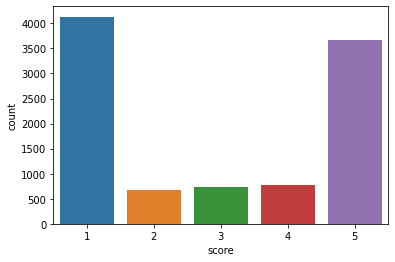

In [15]:
# Plot the count plot for the ratings
sns.countplot(x = reviews_df["score"])
plt.show()

In [16]:
reviews_df = reviews_df[reviews_df["score"] != 3].copy()
reviews_df["sentiment"] = reviews_df["score"].map({1: 0, 2: 0, 4: 1, 5: 1})

# III. Exploratory Data Analysis (EDA)

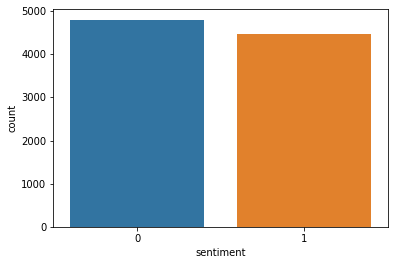

In [17]:
sns.countplot(x = reviews_df["sentiment"])
plt.show()

In [18]:
reviews_df.nunique()

userName                7089
content                 9016
score                      4
thumbsUpCount            185
reviewCreatedVersion      55
at                      9252
sentiment                  2
dtype: int64

In [19]:
def get_num_words(review_text: str) -> int:
  if len(review_text) == 0:
    n_words = 0
  else:
    n_words = re.sub("\s+", "XxX", review_text).count("XxX") + 1
  return n_words

In [20]:
# Let's get the length of the content column

reviews_df["length_char"] = reviews_df["content"].apply(len)
reviews_df["length_words"] = reviews_df["content"].apply(get_num_words)

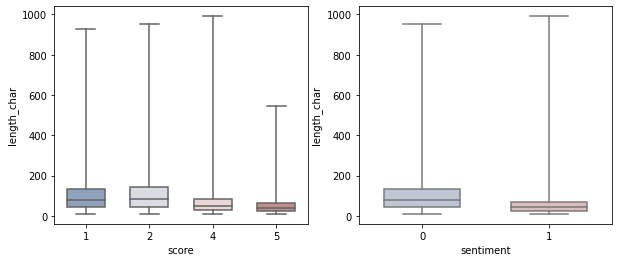

In [21]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
sns.boxplot(y="length_char", x="score", data=reviews_df,
            whis=[0, 100], width=.6, palette="vlag", ax=axes[0])
sns.boxplot(y="length_char", x="sentiment", data=reviews_df,
            whis=[0, 100], width=.6, palette="vlag", ax=axes[1])
plt.show()

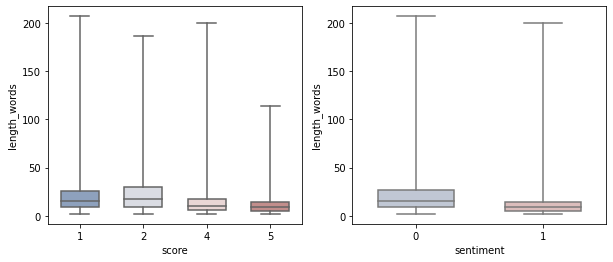

In [22]:
fig, axes = plt.subplots(figsize=(10, 4), ncols=2)
sns.boxplot(y="length_words", x="score", data=reviews_df,
            whis=[0, 100], width=.6, palette="vlag", ax=axes[0])
sns.boxplot(y="length_words", x="sentiment", data=reviews_df,
            whis=[0, 100], width=.6, palette="vlag", ax=axes[1])
plt.show()

Observation: Negative reviews tend to be longer than positive reviews.

<AxesSubplot:ylabel='Frequency'>

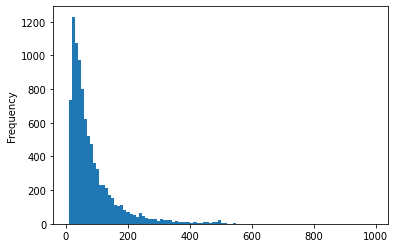

In [23]:
# Plot the histogram for the length
reviews_df["length_char"].plot(bins=100, kind="hist")

In [24]:
# Apply the describe method to get statistical summary
reviews_df.describe().round(2)

,score,thumbsUpCount,sentiment,length_char,length_words
count,9261.00,9261.00,9261.00,9261.00,9261.00
mean,2.91,6.34,0.48,83.65,16.58
std,1.88,46.47,0.50,80.93,15.79
min,1.00,0.00,0.00,10.00,2.00
25%,1.00,0.00,0.00,33.00,7.00
50%,2.00,0.00,0.00,57.00,11.00
75%,5.00,1.00,1.00,104.00,21.00
max,5.00,2641.00,1.00,991.00,207.00


# IV. Text Preprocessing

In [26]:
negative_stopwords = [
    ' no', ' nor', 'not', 'only', 'dont', ' aint', 'arent', 'couldnt', 'didnt',
    'doesnt', 'hadnt', 'hasnt', 'havent', 'isnt', 'shouldnt', 'wasnt', 'werent',
     'wont', 'wouldnt']

In [27]:
def remove_punctuation(message):
  punc_removed = "".join(
      [char for char in message if char not in punctuation])
  return punc_removed

In [28]:
def combine_negative_sw(message):
  for nsw in negative_stopwords:
    message = message.replace(nsw + " ", nsw + "XncX")
  return message

In [29]:
def remove_stopwords_lc(word_list):
  filtered_words = [
      word for word in word_list 
      if word not in stopwords.words('english')]
  return filtered_words

In [30]:
def get_bigrams(word_list):
  bigrams = [
      "_".join([word_list[i], word_list[i+1]]) 
      for i in range(len(word_list) - 1)]
  return bigrams

In [31]:
def get_bigrams_no_double_sw(word_list):
  sw_inds = [
      ind for ind in range(len(word_list)) 
      if word_list[ind] in stopwords.words('english')]
  double_sw_inds = [ind for ind in sw_inds if ind+1 in sw_inds]
  bigrams = [
      "_".join([word_list[i], word_list[i+1]]) 
      for i in range(len(word_list) - 1) if i not in double_sw_inds]
  return bigrams

In [32]:
def get_bigrams_no_sw(word_list):
  non_sw_inds = [
      ind for ind in range(len(word_list)) 
      if word_list[ind] not in stopwords.words('english')]
  bigrams = [
      "_".join([word_list[i], word_list[i+1]]) 
      for i in non_sw_inds if i+1 in non_sw_inds]
  return bigrams

In [33]:
def get_trigrams(word_list):
  trigrams = [
      "_".join(word_list[i: i+3])  
      for i in range(len(word_list) - 2)]
  return trigrams

In [34]:
def get_trigrams_no_triple_sw(word_list):
  sw_inds = [
      ind for ind in range(len(word_list)) 
      if word_list[ind] in stopwords.words('english')]
  triple_sw_inds = [ind for ind in sw_inds 
                    if (ind+1 in sw_inds) and (ind+2 in sw_inds)]
  trigrams = [
      "_".join(word_list[i: i+3]) for i in range(len(word_list) - 2) 
      if i not in triple_sw_inds]
  return trigrams

In [35]:
reviews_df["rev_no_punc"] = reviews_df["content"].apply(
    lambda x: x.replace("+", "plus"))
reviews_df["rev_no_punc"] = reviews_df["rev_no_punc"].str.lower().apply(
    remove_punctuation)
reviews_df["rev_neg_comb"] = reviews_df["rev_no_punc"].apply(
    combine_negative_sw)

In [36]:
reviews_df["unigrams"] = reviews_df["rev_no_punc"].str.split()
reviews_df["unigrams_nosw"] = reviews_df["unigrams"].apply(
    remove_stopwords_lc)

In [37]:
reviews_df["unigrams_nc"] = reviews_df["rev_neg_comb"].str.split()
reviews_df["unigrams_nosw_nc"] = reviews_df["unigrams_nc"].apply(
    remove_stopwords_lc)

In [38]:
reviews_df["bigrams"] = reviews_df["unigrams"].apply(get_bigrams)
reviews_df["bigrams_nodblsw"] = reviews_df["unigrams"].apply(
    get_bigrams_no_double_sw)
reviews_df["bigrams_nosw"] = reviews_df["unigrams"].apply(get_bigrams_no_sw)

In [39]:
reviews_df["bigrams_nc"] = reviews_df["unigrams_nc"].apply(get_bigrams)
reviews_df["bigrams_nodblsw_nc"] = reviews_df["unigrams_nc"].apply(
    get_bigrams_no_double_sw)
reviews_df["bigrams_nosw_nc"] = reviews_df["unigrams_nc"].apply(
    get_bigrams_no_sw)

In [40]:
reviews_df["trigrams"] = reviews_df["unigrams"].apply(get_trigrams)
reviews_df["trigrams_nc"] = reviews_df["unigrams_nc"].apply(get_trigrams)

In [41]:
reviews_df["trigrams_notplsw_nc"] = reviews_df["unigrams_nc"].apply(
    get_trigrams)


In [42]:
reviews_df = reviews_df[reviews_df["unigrams"].apply(len) > 0].copy()

In [43]:
gram_cols = [
    'unigrams_nosw', 'unigrams_nc', 'unigrams_nosw_nc', 'bigrams',
    'bigrams_nodblsw', 'bigrams_nosw', 'bigrams_nc', 'bigrams_nodblsw_nc',
    'bigrams_nosw_nc', 'trigrams', 'trigrams_nc', 'trigrams_notplsw_nc']

for c in gram_cols:
  reviews_df[c + "_is_zero"] = reviews_df[c].apply(lambda x: len(x) == 0)

In [44]:
gram_zero_cols = [c + "_is_zero" for c in gram_cols]

In [45]:
zero_cts = reviews_df.groupby(gram_zero_cols)["sentiment"].count().reset_index()

In [46]:
zero_cts = zero_cts.rename(
    columns={c: c.replace("_is_zero", "").replace("_", " ") 
    for c in gram_zero_cols})

In [47]:
zero_cts

,unigrams nosw,unigrams nc,unigrams nosw nc,bigrams,bigrams nodblsw,bigrams nosw,bigrams nc,bigrams nodblsw nc,bigrams nosw nc,trigrams,trigrams nc,trigrams notplsw nc,sentiment
0,False,False,False,False,False,False,False,False,False,False,False,False,7904
1,False,False,False,False,False,False,False,False,False,False,True,True,21
2,False,False,False,False,False,False,False,False,False,True,True,True,4
3,False,False,False,False,False,False,False,False,True,False,False,False,88
4,False,False,False,False,False,False,False,False,True,False,True,True,11
5,False,False,False,False,False,False,True,True,True,False,True,True,1
6,False,False,False,False,False,False,True,True,True,True,True,True,9
7,False,False,False,False,False,True,False,False,False,False,False,False,41
8,False,False,False,False,False,True,False,False,False,False,True,True,3
9,False,False,False,False,False,True,False,False,True,False,False,False,1157


In [48]:
zero_cts[list(zero_cts)[5:]]

,bigrams nosw,bigrams nc,bigrams nodblsw nc,bigrams nosw nc,trigrams,trigrams nc,trigrams notplsw nc,sentiment
0,False,False,False,False,False,False,False,7904
1,False,False,False,False,False,True,True,21
2,False,False,False,False,True,True,True,4
3,False,False,False,True,False,False,False,88
4,False,False,False,True,False,True,True,11
5,False,True,True,True,False,True,True,1
6,False,True,True,True,True,True,True,9
7,True,False,False,False,False,False,False,41
8,True,False,False,False,False,True,True,3
9,True,False,False,True,False,False,False,1157


In [49]:
temp_cols = [
 'bigrams',
  'bigrams nc',
  'bigrams nosw nc',
 'bigrams nosw',
 'trigrams',
 'trigrams nc',
 'rating']

In [50]:
for c in ["bigrams_nc", "bigrams_nodblsw_nc", "bigrams_nosw_nc"]:
  reviews_df[c] = reviews_df[["bigrams", c, c + "_is_zero"]].apply(
      lambda row: row[c] if not row[c + "_is_zero"] else row["bigrams"], axis=1)

In [51]:
reviews_df[["bigrams", "bigrams_nc", "bigrams_nc" + "_is_zero"]].apply(
    lambda row: row["bigrams_nc"] if not row["bigrams_nc" + "_is_zero"] else row["bigrams"], axis=1)

0       [the_app, app_used, used_to, to_work, work_ver...
1       [sends_full, full_resolution, resolution_vids,...
2       [they_took, took_my, my_💰, 💰_money, money_4, 4...
4       [please_dontXncXdo, dontXncXdo_anymore, anymor...
5       [call_quality, quality_just, just_fine, fine_n...
                              ...                        
9994           [i_really, really_like, like_the, the_app]
9995    [its_notXncXletting, notXncXletting_me, me_sig...
9996    [i_am, am_looking, looking_for, for_women, wom...
9997          [i_cant, cant_venify, venify_my, my_number]
9998    [i_cannotXncXchange, cannotXncXchange_the, the...
Length: 9261, dtype: object

In [52]:
reviews_df[reviews_df["bigrams_nc_is_zero"]][
    ["rev_no_punc", "bigrams", "bigrams_nc"]]

,rev_no_punc,bigrams,bigrams_nc
8156,doesnt work,[doesnt_work],[doesnt_work]
8427,doesnt work,[doesnt_work],[doesnt_work]
8428,doesnt work,[doesnt_work],[doesnt_work]
8429,doesnt work,[doesnt_work],[doesnt_work]
8430,doesnt work,[doesnt_work],[doesnt_work]
8500,doesnt work,[doesnt_work],[doesnt_work]
8501,doesnt work,[doesnt_work],[doesnt_work]
9054,didnt work,[didnt_work],[didnt_work]
9557,wont work,[wont_work],[wont_work]
9652,not workingnot goid,"[not_workingnot, workingnot_goid]","[not_workingnot, workingnot_goid]"


In [53]:
# remove "of" from raw sentence?

In [54]:
reviews_df[reviews_df["bigrams_nosw_is_zero"]][
    ["sentiment", "rev_no_punc", "bigrams", "trigrams", "bigrams_nosw_nc"]]

,sentiment,rev_no_punc,bigrams,trigrams,bigrams_nosw_nc
672,1,i think this apps is greatfunand it allows you...,"[i_think, think_this, this_apps, apps_is, is_g...","[i_think_this, think_this_apps, this_apps_is, ...","[i_think, think_this, this_apps, apps_is, is_g..."
1365,1,i like the app very much i get to talk and see...,"[i_like, like_the, the_app, app_very, very_muc...","[i_like_the, like_the_app, the_app_very, app_v...","[i_like, like_the, the_app, app_very, very_muc..."
1546,1,this app is good but sometimes it says your bu...,"[this_app, app_is, is_good, good_but, but_some...","[this_app_is, app_is_good, is_good_but, good_b...","[this_app, app_is, is_good, good_but, but_some..."
1562,0,it was fine at first then i had to reset my ph...,"[it_was, was_fine, fine_at, at_first, first_th...","[it_was_fine, was_fine_at, fine_at_first, at_f...",[would_notXncXlet]
1669,0,unable to register only for us,"[unable_to, to_register, register_only, only_f...","[unable_to_register, to_register_only, registe...","[register_onlyXncXfor, onlyXncXfor_us]"
...,...,...,...,...,...
9958,1,i think this app is a blessing,"[i_think, think_this, this_app, app_is, is_a, ...","[i_think_this, think_this_app, this_app_is, ap...","[i_think, think_this, this_app, app_is, is_a, ..."
9960,1,this is the most ive been on imo,"[this_is, is_the, the_most, most_ive, ive_been...","[this_is_the, is_the_most, the_most_ive, most_...","[this_is, is_the, the_most, most_ive, ive_been..."
9969,1,very good to use,"[very_good, good_to, to_use]","[very_good_to, good_to_use]","[very_good, good_to, to_use]"
9970,1,very good to use,"[very_good, good_to, to_use]","[very_good_to, good_to_use]","[very_good, good_to, to_use]"


In [55]:
for c in gram_cols:
  #reviews_df[c + "_len"] = reviews_df[c].apply(len)
  reviews_df[c] = reviews_df[c].map(" ".join)

In [56]:
train_df, test_df = train_test_split(reviews_df, test_size=0.2, random_state=0)

# V. Machine Learning Models

These algorithms consist of two parts:

*   A **Count Vectorizer** that transforms a  bag-of-words into a count vector
*   A **Classifier** that predicts the sentiment of the review.



## V.A. partition data to exclude null values.

Not all observations in the dataset contain bigrams and trigrams. Therefore, when evaluating which hyperparamter is best, we can only compare performance on observations that have these features. If bigrams or trigrams prove to be the best hyperparameter, we can use an alternative method to fit the observations for which this data is not available.

In [57]:
unigram_cols = ['unigrams_nosw','unigrams_nc', 'unigrams_nosw_nc']
bigrams_plus_cols = unigram_cols + [
    'bigrams', 'bigrams_nodblsw', 'bigrams_nc', "bigrams_nodblsw_nc"]
bigrams2_plus_cols = bigrams_plus_cols + ["bigrams_nosw", "bigrams_nosw_nc"]
trigrams_plus_cols = [
    'unigrams_nosw','unigrams_nc', 'unigrams_nosw_nc', 
    'trigrams', 'trigrams_nc', 'trigrams_notplsw_nc']

train_bg_df = train_df[~train_df["bigrams_nodblsw_nc_is_zero"]].copy()
train_bg2_df = train_bg_df[~train_bg_df["bigrams_nosw_nc_is_zero"]].copy()
train_tg_df = train_df[~train_df["trigrams_notplsw_nc_is_zero"]].copy()

gram_dict = {
    "uni": {"hp": {"fs__text_col": unigram_cols,
                   "ctvec__min_df": [1, 2, 3, 5]}, 
            "df": train_df}, 
    "bi": {"hp": {"fs__text_col": bigrams_plus_cols,
                   "ctvec__min_df": [1, 2, 3, 5]}, 
            "df": train_bg_df},
    "bi2": {"hp": {"fs__text_col": bigrams2_plus_cols,
                   "ctvec__min_df": [1, 2, 3, 5]}, 
            "df": train_bg2_df},
    "tri": {"hp": {"fs__text_col": trigrams_plus_cols,
                   "ctvec__min_df": [1, 2, 3, 5]}, 
            "df": train_tg_df},
             }


## V.B. build pipelines

In [58]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, text_col=""):
        self.text_col = text_col

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.text_col]

In [59]:
ctvec = CountVectorizer(analyzer = "word")
mnb = MultinomialNB()
cnb = ComplementNB()
dt = DecisionTreeClassifier(min_samples_split=10)
svc = SVC(kernel="linear")

In [60]:
pipe_fs_cnb = Pipeline([
    ("fs", FeatureSelector()), ("ctvec", ctvec), ("cnb", cnb)])

In [61]:
pipe_fs_mnb = Pipeline([
    ("fs", FeatureSelector()), ("ctvec", ctvec), ("mnb", mnb)])

In [62]:
pipe_fs_dt = Pipeline([
    ("fs", FeatureSelector()), ("ctvec", ctvec), ("dt", dt)])

In [63]:
pipe_fs_svc = Pipeline([
    ("fs", FeatureSelector()), ("ctvec", ctvec), ("svc", svc)])


### V.C. Fit pipelines

In [9]:
def summarize_gs(gs):
    """Prints best test (validation) score of a fitted GridSearchCV object
    Parameters
    ------------
    gs : fitted GridSearchCV object
    
    Returns
    -------
    None
    """
    print("Best Parameters:", gs.best_params_)
    gs_std_test_score = gs.cv_results_["std_test_score"][gs.best_index_]
    print("Best Score: %.3f +/- %.3f" % (gs.best_score_, gs_std_test_score))


In [ ]:
gram_method = "bi"

gs_bigram_cnb = GridSearchCV(
    estimator=pipe_fs_cnb, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_bigram_cnb = gs_bigram_cnb.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_bigram_cnb)

Best Parameters: {'ctvec__min_df': 1, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.893 +/- 0.012


In [ ]:
gram_method = "bi2"

gs_bigram2_cnb = GridSearchCV(
    estimator=pipe_fs_cnb, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_bigram2_cnb = gs_bigram2_cnb.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_bigram2_cnb)

Best Parameters: {'ctvec__min_df': 1, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.891 +/- 0.010


In [ ]:
gram_method = "tri"

gs_trigram_cnb = GridSearchCV(
    estimator=pipe_fs_cnb, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_trigram_cnb = gs_trigram_cnb.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_trigram_cnb)

Best Parameters: {'ctvec__min_df': 1, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.894 +/- 0.010


In [ ]:
gram_method = "bi"

gs_bigram_mnb = GridSearchCV(
    estimator=pipe_fs_mnb, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_bigram_mnb = gs_bigram_mnb.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_bigram_mnb)

Best Parameters: {'ctvec__min_df': 1, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.894 +/- 0.012


In [ ]:
gram_method = "bi2"

gs_bigram2_mnb = GridSearchCV(
    estimator=pipe_fs_mnb, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_bigram2_mnb = gs_bigram2_mnb.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_bigram2_mnb)


Best Parameters: {'ctvec__min_df': 1, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.893 +/- 0.009


In [ ]:
gram_method = "tri"

gs_trigram_mnb = GridSearchCV(
    estimator=pipe_fs_mnb, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_trigram_mnb = gs_trigram_mnb.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_trigram_mnb)

Best Parameters: {'ctvec__min_df': 1, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.894 +/- 0.012


In [ ]:
gram_method = "bi"

gs_bigram_dt = GridSearchCV(
    estimator=pipe_fs_dt, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_bigram_dt = gs_bigram_dt.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_bigram_dt)

Best Parameters: {'ctvec__min_df': 3, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.843 +/- 0.006


In [ ]:
gram_method = "bi2"

gs_bigram2_dt = GridSearchCV(
    estimator=pipe_fs_dt, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_bigram2_dt = gs_bigram2_dt.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_bigram2_dt)

Best Parameters: {'ctvec__min_df': 3, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.837 +/- 0.006


In [ ]:
gram_method = "tri"

gs_trigram_dt = GridSearchCV(
    estimator=pipe_fs_dt, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_trigram_dt = gs_trigram_dt.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_trigram_dt)

Best Parameters: {'ctvec__min_df': 1, 'fs__text_col': 'unigrams_nosw_nc'}
Best Score: 0.842 +/- 0.006


In [ ]:
gram_method = "bi"

gs_bigram_svc = GridSearchCV(
    estimator=pipe_fs_svc, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_bigram_svc = gs_bigram_svc.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_bigram_svc)

Best Parameters: {'ctvec__min_df': 2, 'fs__text_col': 'unigrams_nc'}
Best Score: 0.885 +/- 0.003


In [ ]:
gram_method = "bi2"

gs_bigram2_svc = GridSearchCV(
    estimator=pipe_fs_svc, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_bigram2_svc = gs_bigram2_svc.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_bigram2_svc)

Best Parameters: {'ctvec__min_df': 2, 'fs__text_col': 'unigrams_nc'}
Best Score: 0.877 +/- 0.005


In [64]:
gram_method = "tri"

gs_trigram_svc = GridSearchCV(
    estimator=pipe_fs_svc, param_grid=gram_dict[gram_method]["hp"], 
    scoring="accuracy", return_train_score=True, cv=5, n_jobs=-1)

gs_trigram_svc = gs_trigram_svc.fit(
      gram_dict[gram_method]["df"], 
      gram_dict[gram_method]["df"]["sentiment"])

summarize_gs(gs_trigram_svc)

Best Parameters: {'ctvec__min_df': 2, 'fs__text_col': 'unigrams_nc'}
Best Score: 0.885 +/- 0.003


# VI. Conclusion

Best Model: Complement Naive Bayes<br>
Best Parameters: 
*   ctvec__min_df: 1
*   fs__text_col: unigrams_nosw_nc<br>

Best Score: 0.894 +/- 0.010


Now let's test this model on unseen data:

In [69]:
pipe_fs_cnb.set_params(
    **{"ctvec__min_df": 1, 
       "fs__text_col": "unigrams_nosw_nc"})
pipe_fs_cnb.fit(train_df, train_df["sentiment"])

y_pred_train_cnb = pipe_fs_cnb.predict(train_df)
y_pred_test_cnb = pipe_fs_cnb.predict(test_df)

In [71]:
print(classification_report(train_df["sentiment"], y_pred_train_cnb))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3851
           1       0.93      0.90      0.91      3557

    accuracy                           0.92      7408
   macro avg       0.92      0.92      0.92      7408
weighted avg       0.92      0.92      0.92      7408



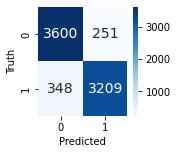

In [73]:
cm = confusion_matrix(train_df["sentiment"].values, y_pred_train_cnb)
fig, ax = plt.subplots(figsize=(2, 2))
ax = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g", annot_kws={"size": 14})
ax.set_xlabel("Predicted")
ax.set_ylabel("Truth")
plt.show()

In [70]:
print(classification_report(test_df["sentiment"], y_pred_test_cnb))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       950
           1       0.91      0.86      0.88       903

    accuracy                           0.89      1853
   macro avg       0.89      0.89      0.89      1853
weighted avg       0.89      0.89      0.89      1853



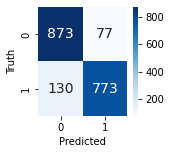

In [72]:
cm = confusion_matrix(test_df["sentiment"].values, y_pred_test_cnb)
fig, ax = plt.subplots(figsize=(2, 2))
ax = sns.heatmap(cm, cmap="Blues", annot=True, fmt="g", annot_kws={"size": 14})
ax.set_xlabel("Predicted")
ax.set_ylabel("Truth")
plt.show()

In [81]:
pd.set_option('max_colwidth', -1)


<ipython-input-81-7020dba1819a>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


It appears that many of the reviews that the model misclassified may have actually reflected a user error. The majority of these scenarios occurred when a user wrote a negative review but gave a 4 or 5 star rating.

In [83]:
# In my opinion, 7 of the 10 errors shown below actually reflect user errors.
train_df[(train_df["sentiment"]!=y_pred_train_cnb )
         & (train_df["sentiment"]==1)][
    ["content", "score", "sentiment"]].iloc[:10]

,content,score,sentiment
6641,What is this pop up update the every time I open the app,5,1
8758,I cant log it in laptop,5,1
9256,This app is very nice but how can i change the country code phone,5,1
9197,I know it's not working,5,1
7862,I have two of them on my phone how do I take the other one off,5,1
6285,Sometimes app doesn't work,4,1
8583,I had this on my old old phon,5,1
5637,It is showing me United states code.and I live in uganda.,5,1
5798,When. I type in my. Mollie number it don't work plz fix,5,1
4719,I cant not log in or get my self in to start imo,5,1


In [84]:
# In my opinion, 1 (the last) of the 10 errors shown below actually reflects user errors.

train_df[(train_df["sentiment"]!=y_pred_train_cnb )
         & (train_df["sentiment"]==0)][
    ["content", "score", "sentiment"]].iloc[:10]

,content,score,sentiment
5662,not a good app for video calls.,1,0
7355,you have to tell your friends to d imo on there phone or ipad,1,0
5356,Too much ad,1,0
3804,"It was good until the update, now it doesnt workkkkkk",1,0
7546,is not working after a bit,1,0
3909,can't share videos anymore....garbage,1,0
2089,I use to love this app but recently I cannot take any calls or messages on it.,1,0
7044,Well before it was good..... But now WHAT IS THIS.,1,0
9755,It was good before update,1,0
8413,Good. But it could be better.,1,0


In [86]:
# In my opinion, 5 of the 10 errors shown below actually reflect user errors.
test_df[(test_df["sentiment"]!=y_pred_test_cnb )
         & (test_df["sentiment"]==1)][
    ["content", "score", "sentiment"]].iloc[:10]

,content,score,sentiment
8165,"Too many updates,",4,1
2341,"I've not used this app enough to make good or bad comments about it. From what I've been told and that's why I'm installing it,|everyone says it's top notch.",4,1
8365,why isn't my im0 upgrade no working,5,1
5695,Try to add multiple features ...calling.,5,1
1933,"i like my rxperience with imo. now this update mess needs more memory than i have to offer. any suggestions? i have 8g max. to incrrase it is a new plan, more money monthly, new phone and transfers.",4,1
5300,"I skipped a step and didn't enter code, I have no icon",5,1
7615,Im having a hard time updating this app,5,1
3579,There's update comes on the screen whenever I want to use the IMO app. Please improve on that,4,1
2308,My app keeps telling me that I need audio permission???,4,1
8342,"pizza, papers. markers notepads",5,1


In [87]:
# In my opinion, none of the 10 errors shown below reflect user errors.
test_df[(test_df["sentiment"]!=y_pred_test_cnb )
         & (test_df["sentiment"]==0)][
    ["content", "score", "sentiment"]].iloc[:10]

,content,score,sentiment
2816,the quality during the call is really bad,2,0
2906,I do not like this app. Can not find or chat with my friends. Bad app...Bad app!!!,1,0
8062,it is out of reach it's really bad,1,0
3516,"No sound when you call, no voice call",1,0
870,"Can not communicate with family abroad all of a sudden , which was the ONLY reason I used this app. Guess going to have to use another app from now on. Good job Penguins.",1,0
5270,Imo when you first get it its realu fun and stuff but now me imo is not wroning real good me dont have that no more,1,0
7743,😣 was a good app until the update,1,0
7592,a huge percentage of low definition in everything.,1,0
3953,When i st to text the camera closes and then I had to go though a process,2,0
7336,Shittiest app I've ever used in my life.,1,0


In [88]:
train_df["predicted_sentiment"] = y_pred_train_cnb
test_df["predicted_sentiment"] = y_pred_test_cnb

In [89]:
train_df[
    "prediction accurate"] = (
        train_df["predicted_sentiment"] == train_df["sentiment"]).astype(int)
test_df[
    "prediction accurate"] = (
        test_df["predicted_sentiment"] == test_df["sentiment"]).astype(int)

The model was most accurate when evaluating reviews with very polar ratings (1 star or 5 stars). Future analysis could focus on improving performance for reviews corresponding to 2 and 4 star ratings.

In [94]:
train_df.groupby("score")["prediction accurate"].agg(["mean", "count"])

,mean,count
score,,
1,0.945987,3314
2,0.865922,537
4,0.816694,611
5,0.919891,2946


In [95]:
test_df.groupby("score")["prediction accurate"].agg(["mean", "count"])

,mean,count
score,,
1,0.936430,818
2,0.810606,132
4,0.739884,173
5,0.883562,730
